EBase: 6 uL Trolox, 3.9 Glycerol, 1.3 uL Ao3/10AO3B, 1.7 uL PkLDH, 4 uL ATeam(1-20-23), 1.3 uL Ao4, 1.2 uL Pluronic/MgCl2

Rxn Mix: 2.26 ul Ebase, 1.74 ul ATP mix, 2ul NCD micro 1/10, 1ul 1:45 AO4

pos0: 1410uM ATP  -- 70um
pos1: 750uM ATP -- 65.4um
pos2: 353uM ATP -- 72um
pos3: 176uM ATP -- 68um
pos4: 88uM ATP -- 76um
pos5: 0uM ATP, 2ul NCD Cherry 1:9 (8/22) yes ATeam -- 80um
pos6: 0uM ATP, 50% M2B glycerol yes ATeam -- 74um
pos7: 0uM ATP, 2ul NCD Cherry 1:9 (8/22) no ATeam -- 82um
pos8: 0uM ATP, M2B, UMT 1:7 NO ATeam -- 76um

LED 100mA, bright Cherry  30ms, Cherry 250ms, proj ATeam CFP 85ms, Proj ATeam YFP 50ms

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Numpy imports:
import numpy as np

#Scipy imports
import scipy
from scipy import optimize
from scipy.optimize import curve_fit

# for extracting filenames
import glob

# skimage submodules we need
import skimage.io
import skimage.measure
import skimage.filters
import skimage.exposure
import skimage.morphology
from skimage.registration import phase_cross_correlation

#For identifying aster center
from skimage.filters import threshold_otsu, gaussian
from skimage.measure import regionprops
import cv2

#Matplotlib imports
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

# # Seaborn imports (stylistic for nice plots)
# import seaborn as sns
# rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14, \
#     'xtick.labelsize' : 14, 'ytick.labelsize' : 14}
# sns.set(style='ticks', rc=rc)

#for DataFrames
import pandas as pd

#To interact with the operating system
import os

#For status bar 
from tqdm.notebook import tqdm as tqdm

In [3]:
import atp_cal

In [4]:
atp_cal.pboc_style_mpl()

# show images in viridis by default (pboc is fire?)
plt.rcParams['image.cmap'] = 'viridis'

## Settings and Functions

#### Image Plotting Settings

In this cell I specify the size of images and the conversion of pixels to µm. As well as, some settings for plotting in holoviews

In [5]:
# Length calibration [microns per pixel]
um_per_pixel = 0.58 #Jan2023 um_per_pixel corrected s.t. it is assuming 10X mag rather than 5X (now don't have to divide by 2)

# Image dimensions
w_px, h_px = 1920, 1200
w_um, h_um = w_px*um_per_pixel, h_px*um_per_pixel

#bounds
bounds = [0, 0, w_um, h_um]

#Set the frame size of the image to enforce square pixels (holoviews does not have this preset)
frame_height = 200
frame_width = w_px * frame_height // h_px

#Preset these settings as opts
opts = dict(
    frame_height=frame_height,
    frame_width=frame_width,
    xlabel="µm",
    ylabel="µm",
    cmap = 'viridis'
)

#### Parameters:
Here list ATP concentration

In [6]:
ATPconc = np.array([1410, 705, 352, 176, 88, 0])

## Import Images

In [7]:
#This should not change between experiments:
datapath = '../../../data/atp_cal'

#This varies between experiments.  
datafolder = '2023-02-07_ATeamCalCurve/2023-02-07_ATeamCalCurve_2/images'

# YFP Images
included_YFP = '*C4*.tif'
YFP_files = np.sort(glob.glob(datapath+'/'+datafolder+'/'+included_YFP))
# CFP Images
included_CFP = '*C3*.tif'
CFP_files = np.sort(glob.glob(datapath+'/'+datafolder+'/'+included_CFP))

# Motor Images (only 2 have motors for bleedthrough controls)
included_Mot = '*C2*.tif'
Mot_files = np.sort(glob.glob(datapath+'/'+datafolder+'/'+included_Mot))

#The ensure images are in order, sort them:
YFP_files_ordered = atp_cal.file_sorter(YFP_files)
CFP_files_ordered = atp_cal.file_sorter(CFP_files)
Mot_files_ordered = atp_cal.file_sorter(Mot_files)

#Read in images and save as array:
YFP_array = atp_cal.file_to_image(YFP_files_ordered)
CFP_array = atp_cal.file_to_image(CFP_files_ordered)
Mot_array = atp_cal.file_to_image(Mot_files_ordered)

# Define the zero concentration image (DO EVERY TIME):
YFP_zero = YFP_array[5] 
CFP_zero = CFP_array[5] 
Mot_zero = Mot_array[5] 

# ------------------------------------------------------------------------------ #

#YFP_bg = atp_cal.file_to_image(np.sort(glob.glob(datapath+'/'+bgfolder+'/'+bgYFP_name)))
YFP_bg = YFP_array[8] 
CFP_bg = CFP_array[8] 
Mot_bg = Mot_array[8] 


In [8]:
#delete the image that is 0uM ATP with no ATeam (this is the bg images imported above), as well as bleedthrough
#images (all images that include motors)
YFP_array = np.delete(YFP_array, [6, 7, 8], axis =0)
CFP_array = np.delete(CFP_array, [6, 7, 8], axis =0)
Mot_array = np.delete(Mot_array, [6, 7, 8], axis =0)

In [9]:
np.shape(YFP_array)

(6, 1200, 1920)

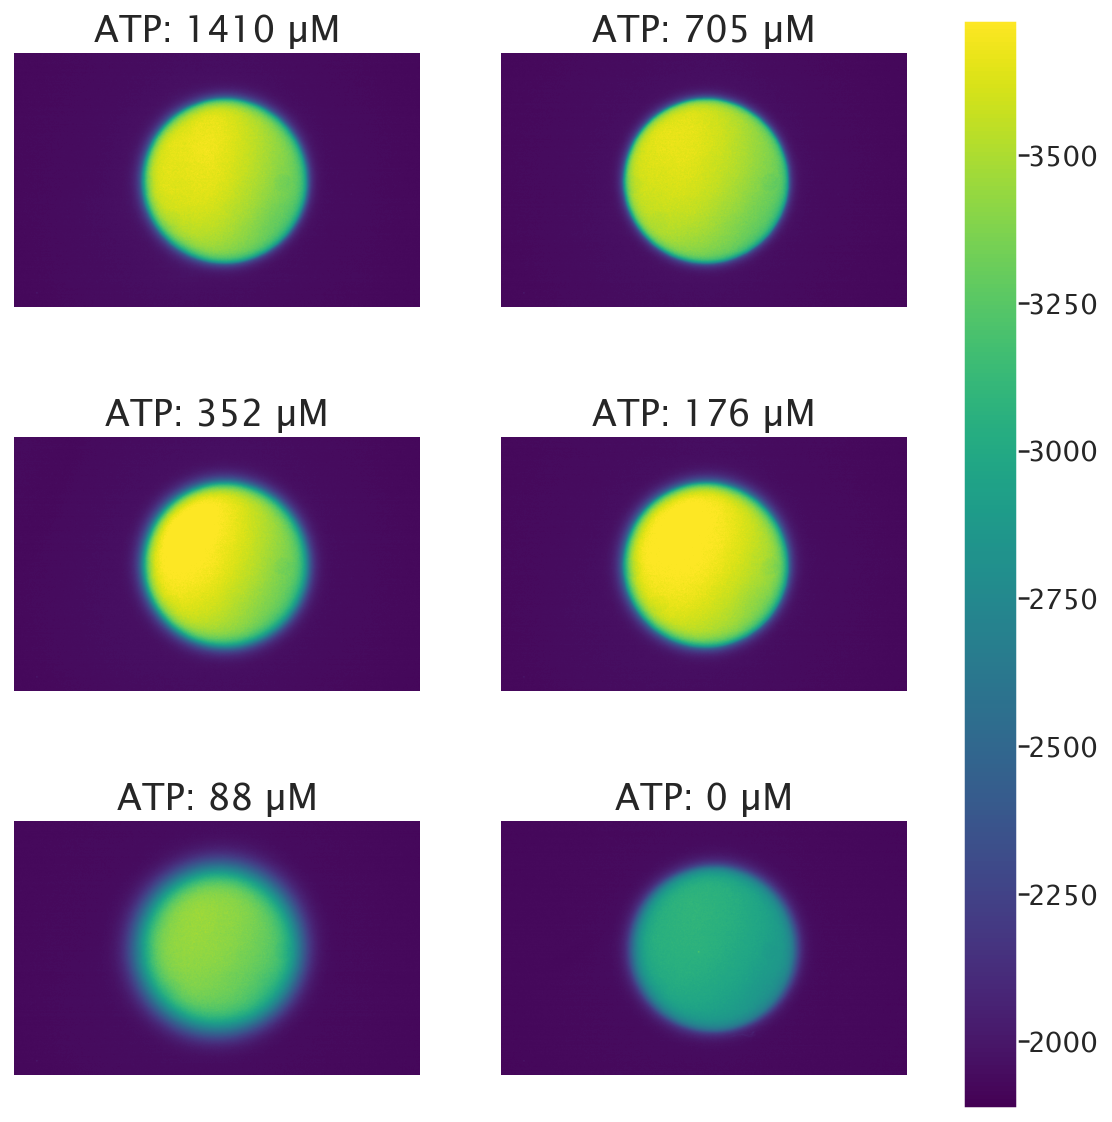

In [10]:
array_to_plot = YFP_array
colorbar_min = np.percentile(YFP_zero, 0)
colorbar_max = np.percentile(array_to_plot, 99)

#The rest is automated
if len(array_to_plot)%2 != 0:
    plot_array = np.concatenate((array_to_plot, np.zeros((1, 1200, 1920))))
    plot_ATPconc = np.concatenate((ATPconc, np.array(['filler'])))
    
else:
    plot_array = array_to_plot
    plot_ATPconc = ATPconc

fig, axes = plt.subplots(nrows=int((len(plot_array)+1)/2), ncols=2, figsize = (10, 10))

cmap=cm.get_cmap('viridis')
normalizer=Normalize(colorbar_min, colorbar_max)
im=cm.ScalarMappable(norm=normalizer)
for i,ax in enumerate(axes.flat):
    ax.imshow((plot_array[i]),cmap=cmap,norm=normalizer)
    ax.set_title('ATP: ' + str(plot_ATPconc[i]) + ' µM')
    ax.axis('off')
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()


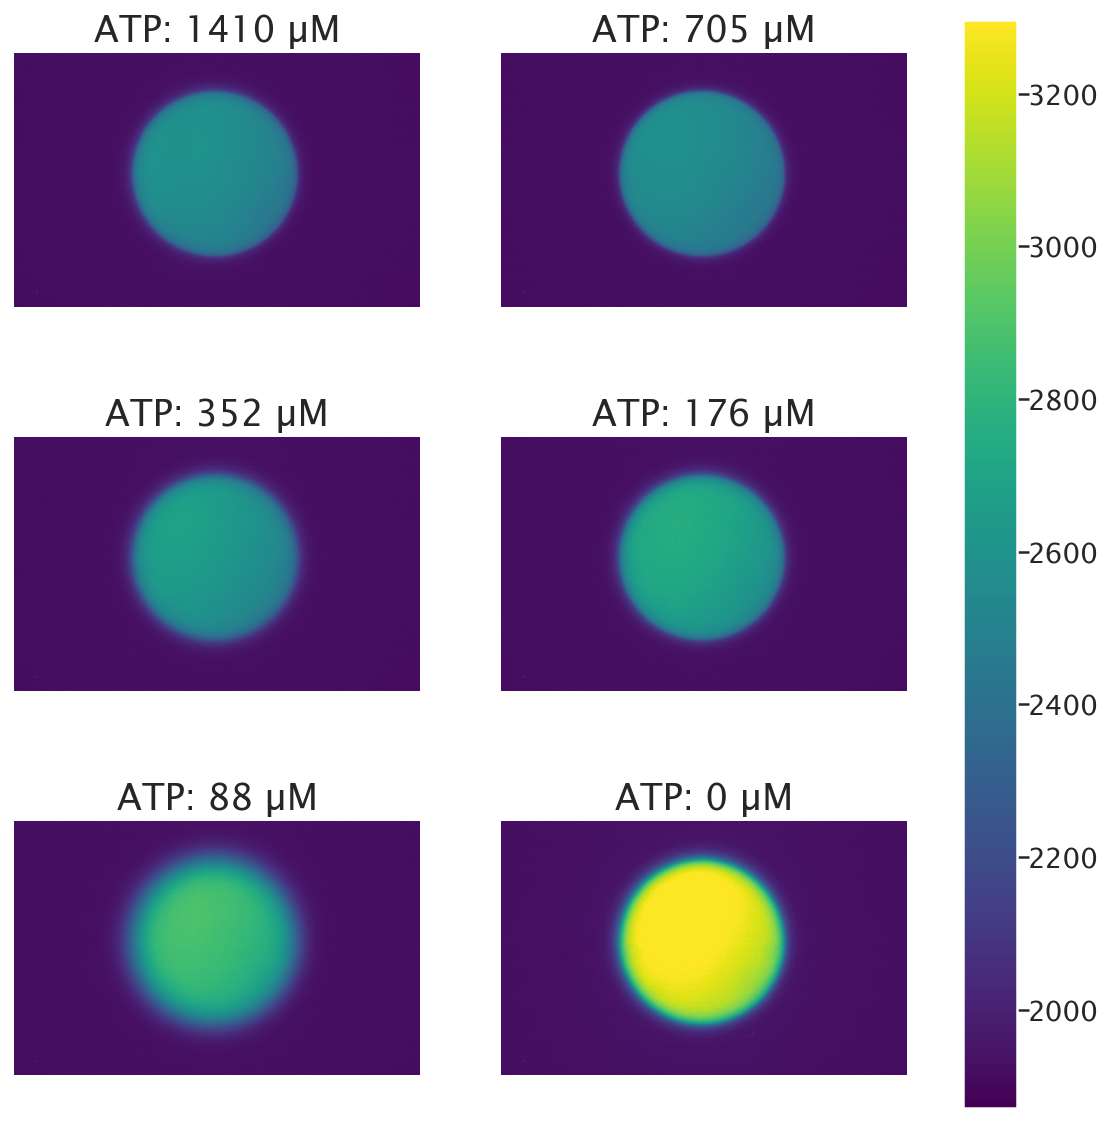

In [11]:
array_to_plot = CFP_array
colorbar_min = np.percentile(CFP_zero, 0)
colorbar_max = np.percentile(array_to_plot, 99)

#The rest is automated
if len(array_to_plot)%2 != 0:
    plot_array = np.concatenate((array_to_plot, np.zeros((1, 1200, 1920))))
    plot_ATPconc = np.concatenate((ATPconc, np.array(['filler'])))
    
else:
    plot_array = array_to_plot

fig, axes = plt.subplots(nrows=int((len(plot_array)+1)/2), ncols=2, figsize = (10, 10))

cmap=cm.get_cmap('viridis')
normalizer=Normalize(colorbar_min, colorbar_max)
im=cm.ScalarMappable(norm=normalizer)
for i,ax in enumerate(axes.flat):
    ax.imshow((plot_array[i]),cmap=cmap,norm=normalizer)
    ax.set_title('ATP: ' + str(plot_ATPconc[i]) + ' µM')
    ax.axis('off')
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()


## Subtract background and correct for uneven illumination background subtraction

In [12]:
#Subtract im_dark from all calibration images
YFP_bs = YFP_array - YFP_bg
CFP_bs = CFP_array - CFP_bg
Mot_bs = Mot_array - Mot_bg

Set any negative values to zero

In [13]:
CFP_bs[CFP_bs<0] = 0
YFP_bs[YFP_bs<0] = 0
Mot_bs[CFP_bs<0] = 0

## Bianary image circular mask:

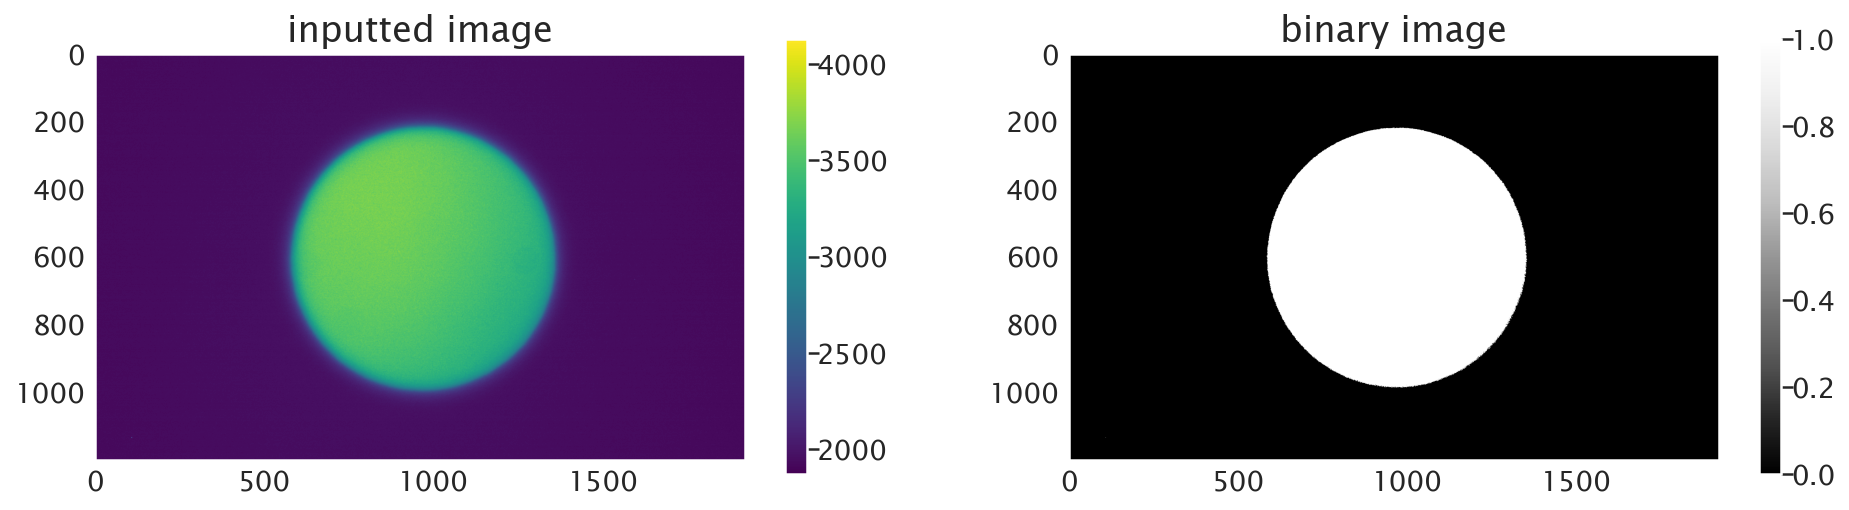

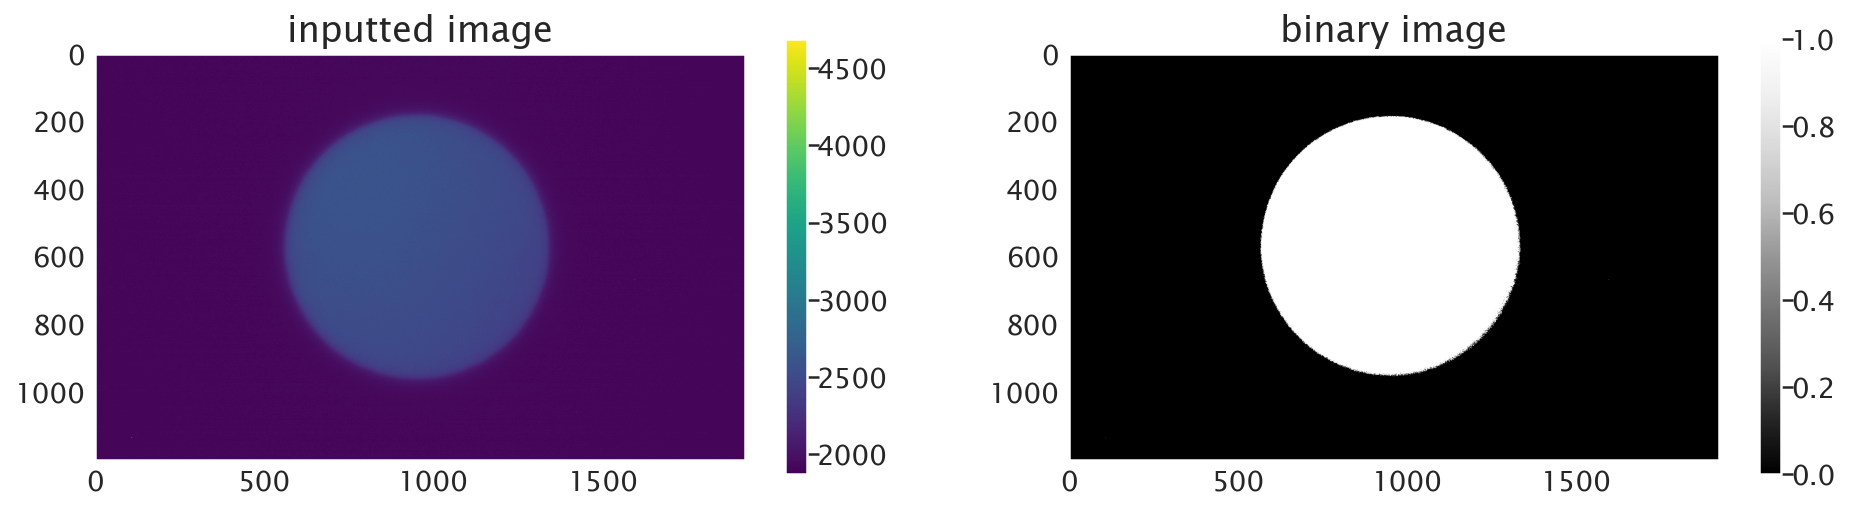

In [14]:
im_binary_YFP = atp_cal.binary_im_generator(YFP_array[1])
im_binary_CFP = atp_cal.binary_im_generator(CFP_array[1])

Multiply images by the binary mask. Define background offset from the zero ATeam zero ATP condition. This takes into account camera signal and autofluorescence

In [15]:
YFP_bin = YFP_bs*im_binary_YFP
CFP_bin = CFP_bs*im_binary_CFP
Mot_bin = Mot_bs*im_binary_YFP

# Define an average offset
YFP_bg_offset = np.average(np.nonzero(YFP_bg*im_binary_YFP))
CFP_bg_offset = np.average(np.nonzero(CFP_bg*im_binary_CFP))
Mot_bg_offset = np.average(np.nonzero(Mot_bg*im_binary_YFP))
YFP_bg_offset

784.2429078399736

Create a normalization matrix using the zero ATP (yes ATeam) concentration and the defined offset value - note the zero ATP image defiinition has yet to be background subtracted. This occurs in the normalization function

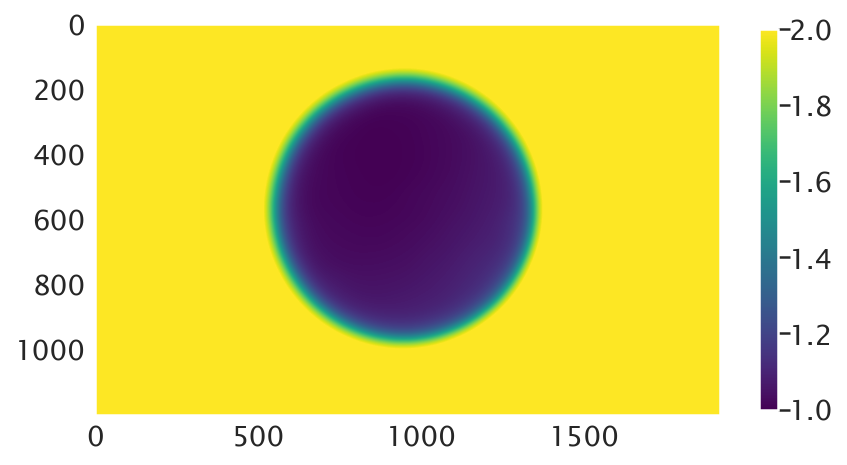

In [16]:
#Find the normilization matrix
YFP_norm_mat = atp_cal.norm_mat_fn_iATP(YFP_zero, YFP_bg_offset)
CFP_norm_mat = atp_cal.norm_mat_fn_iATP(CFP_zero, CFP_bg_offset)
Mot_norm_mat = atp_cal.norm_mat_fn_iATP(Mot_zero, Mot_bg_offset)

#plot the normalizaiton matrix
plt.imshow(CFP_norm_mat, vmin = 1, vmax = 2)
plt.colorbar(shrink = 0.7)
plt.grid(False)

multiply the images by the normalization matrix

In [17]:
#Normalize all the claibration images by multiplying by the normalization matrix
YFP_norm = YFP_bin*YFP_norm_mat
CFP_norm = CFP_bin*CFP_norm_mat
Mot_norm = Mot_bin*Mot_norm_mat

In [18]:
print(CFP_bs.min())
print(CFP_norm_mat.min())
print(CFP_bin.min())
print(YFP_bs.min())
print(YFP_norm_mat.min())
print(YFP_bin.min())

0
1.0000015792330643
0
0
1.0000019863577592
0


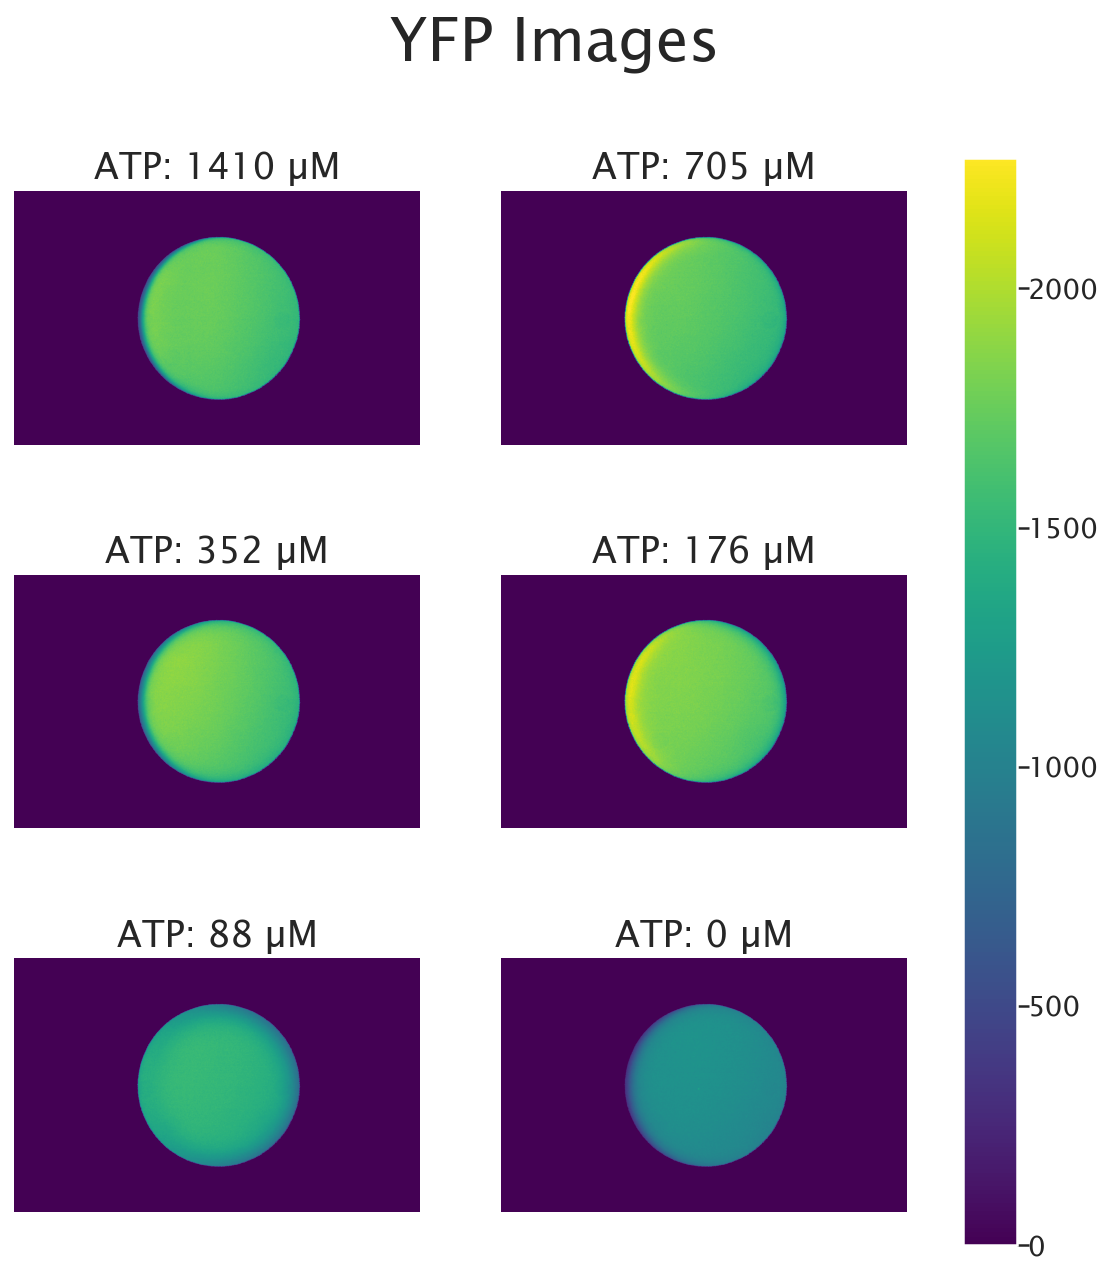

In [19]:
array_to_plot = YFP_norm
colorbar_min = np.percentile(array_to_plot, 0)
colorbar_max = np.percentile(array_to_plot, 99.99)

#Rest is automated
if len(array_to_plot)%2 != 0:
    plot_array = np.concatenate((array_to_plot, np.zeros((1, 1200, 1920))))
    plot_ATPconc = np.concatenate((ATPconc, np.array(['filler'])))
else:
    plot_array = array_to_plot

fig, axes = plt.subplots(nrows=int((len(plot_array)+1)/2), ncols=2, figsize = (10, 10))

cmap=cm.get_cmap('viridis')
normalizer=Normalize(colorbar_min, colorbar_max)
im=cm.ScalarMappable(norm=normalizer)
for i,ax in enumerate(axes.flat):
    ax.imshow((plot_array[i]),cmap=cmap,norm=normalizer)
    ax.set_title('ATP: ' + str(plot_ATPconc[i]) + ' µM')
    ax.axis('off')
plt.suptitle('YFP Images', fontsize=30)
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

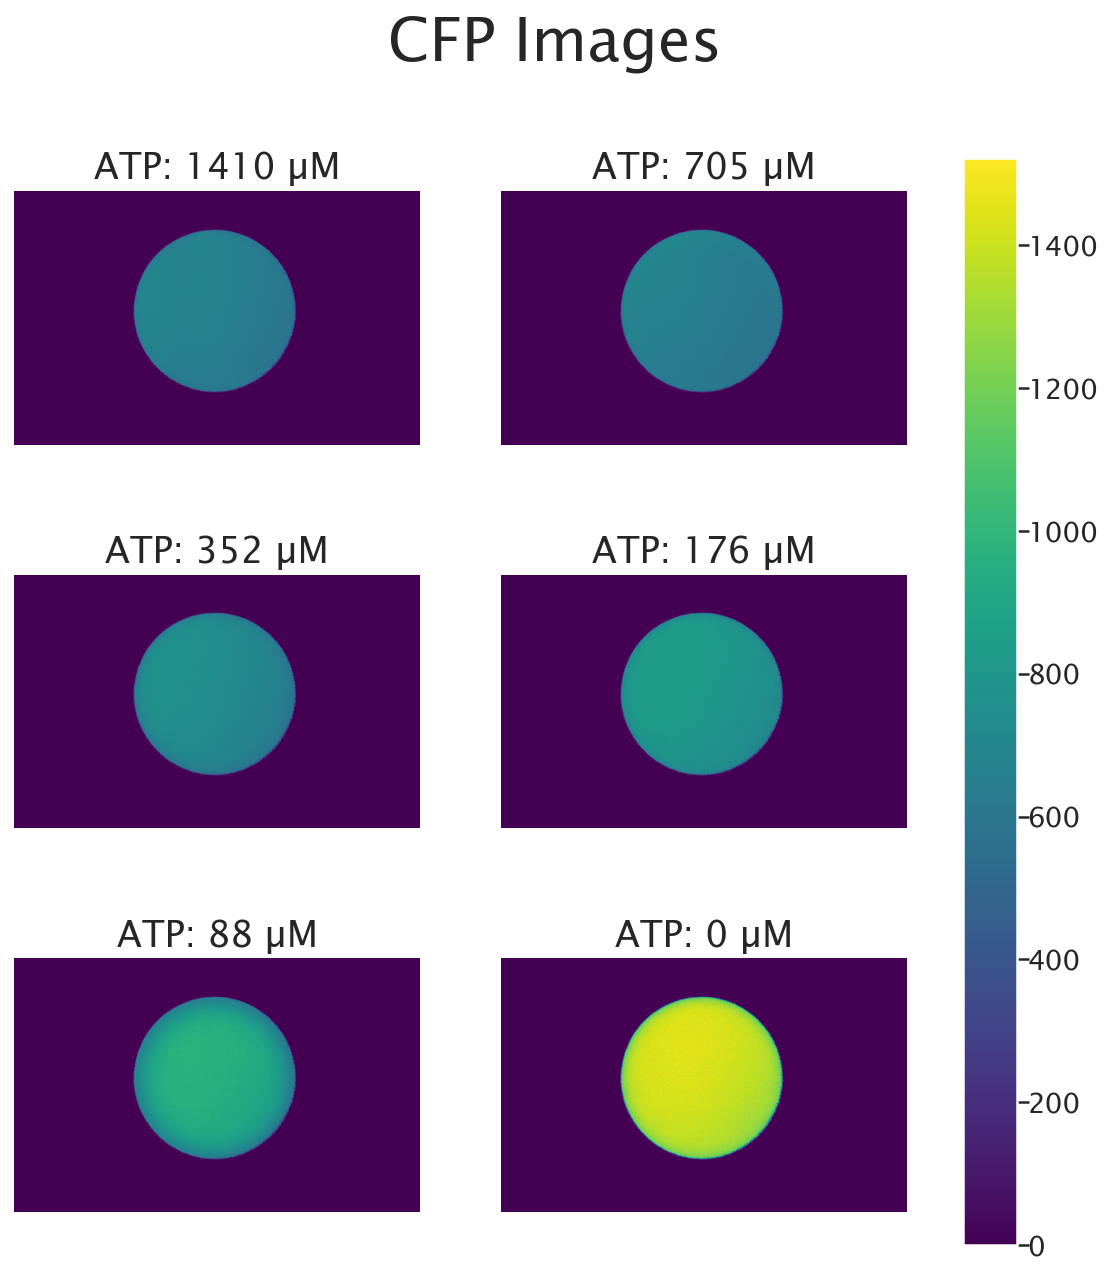

In [20]:
array_to_plot = CFP_norm
colorbar_min = np.percentile(array_to_plot, 0)
colorbar_max = np.percentile(array_to_plot, 99.99)

#Rest is automated
if len(array_to_plot)%2 != 0:
    plot_array = np.concatenate((array_to_plot, np.zeros((1, 1200, 1920))))
    plot_ATPconc = np.concatenate((ATPconc, np.array(['filler'])))
else:
    plot_array = array_to_plot

fig, axes = plt.subplots(nrows=int((len(plot_array)+1)/2), ncols=2, figsize = (10, 10))

cmap=cm.get_cmap('viridis')
normalizer=Normalize(colorbar_min, colorbar_max)
im=cm.ScalarMappable(norm=normalizer)
for i,ax in enumerate(axes.flat):
    ax.imshow((plot_array[i]),cmap=cmap,norm=normalizer)
    ax.set_title('ATP: ' + str(plot_ATPconc[i]) + ' µM')
    ax.axis('off')
    
plt.suptitle('CFP Images', fontsize=30)
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

### Find Center

In [21]:
def center(im_array):
    centers = []

    for i, im in enumerate(tqdm(im_array)):
        #Create a binary mask for above a threshold
        thresh = threshold_otsu(im) #Otsu threshold method
        binary = (im>thresh).astype(np.uint8)
        
        
        properties = regionprops(binary, im)
        center = properties[0].centroid
        center = [round(center[0]), round(center[1])]
        centers.append(center)
        
    return centers


In [22]:
YFP_centers = center(YFP_norm)
CFP_centers = center(CFP_norm)
print('center shifts: YFP + ' + str([YFP_centers[0][0]-CFP_centers[0][0], YFP_centers[0][1]-CFP_centers[0][1]]) + ' = CFP')

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

center shifts: YFP + [36, 25] = CFP


In [23]:
radius = 385
sidelength = int(radius/np.sqrt(2))

YFP_circlecrop = []
for i, im in enumerate(tqdm(YFP_norm)):
    im_crop = im[YFP_centers[i][0] - radius : YFP_centers[i][0] + radius,
                YFP_centers[i][1] - radius : YFP_centers[i][1] + radius]
    YFP_circlecrop.append(im_crop)
    
YFP_squarecrop = []
for i, im in enumerate(tqdm(YFP_norm)):
    im_crop = im[YFP_centers[i][0] - sidelength : YFP_centers[i][0] + sidelength,
                YFP_centers[i][1] - sidelength : YFP_centers[i][1] + sidelength]
    YFP_squarecrop.append(im_crop)
    
CFP_circlecrop = []
for i, im in enumerate(tqdm(CFP_norm)):
    im_crop = im[int(CFP_centers[i][0]) - radius : int(CFP_centers[i][0]) + radius ,
                int(CFP_centers[i][1]) - radius : int(CFP_centers[i][1]) + radius]
    CFP_circlecrop.append(im_crop)

CFP_squarecrop = []
for i, im in enumerate(tqdm(CFP_norm)):
    im_crop = im[int(CFP_centers[i][0]) - sidelength : int(CFP_centers[i][0]) + sidelength ,
                int(CFP_centers[i][1]) - sidelength : int(CFP_centers[i][1]) + sidelength]
    CFP_squarecrop.append(im_crop)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_52068/3839405452.py:3: RuntimeWarning: divide by zero encountered in true_divide
  im = (YFP_circlecrop[i]/CFP_circlecrop[i])
/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_52068/3839405452.py:3: RuntimeWarning: invalid value encountered in true_divide
  im = (YFP_circlecrop[i]/CFP_circlecrop[i])


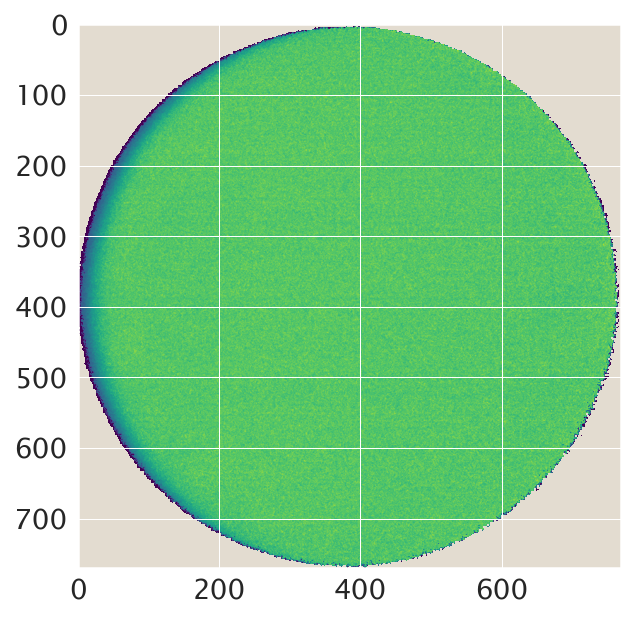

In [24]:
ratio_circlecrop =[]
for i in range(len(YFP_circlecrop)):
    im = (YFP_circlecrop[i]/CFP_circlecrop[i])
    im[np.where(im==np.inf)] = 0
    ratio_circlecrop.append(im)
ratio_circlecrop = np.array(ratio_circlecrop)
plt.imshow(ratio_circlecrop[0])

/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_52068/2739240886.py:3: RuntimeWarning: divide by zero encountered in true_divide
  im = (YFP_squarecrop[i]/CFP_squarecrop[i])
/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_52068/2739240886.py:3: RuntimeWarning: invalid value encountered in true_divide
  im = (YFP_squarecrop[i]/CFP_squarecrop[i])


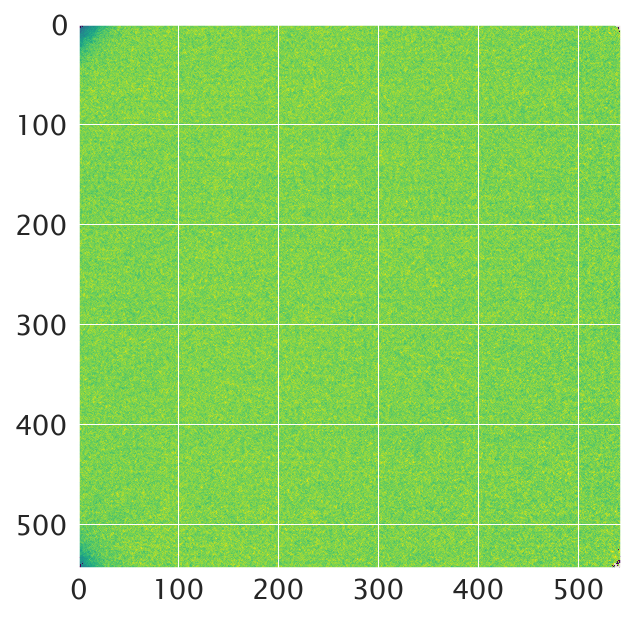

In [25]:
ratio_squarecrop =[]
for i in range(len(YFP_squarecrop)):
    im = (YFP_squarecrop[i]/CFP_squarecrop[i])
    im[np.where(im==np.inf)] = 0
    ratio_squarecrop.append(im)
ratio_squarecrop = np.array(ratio_squarecrop)
plt.imshow(ratio_squarecrop[0])

## Calculate the average intensity value per concentration

Average all images inside of the binary mask

In [26]:
#Average over the non-zero values in the image to get the calibration
YFP_calavg = np.empty(len(YFP_squarecrop))
for i, im in enumerate(YFP_squarecrop):
    YFP_calavg[i] = np.average(im[np.nonzero(im)])
    
CFP_calavg = np.empty(len(CFP_squarecrop))
for i, im in enumerate(CFP_squarecrop):
    CFP_calavg[i] = np.average(im[np.nonzero(im)])
    
#ratio_calavg = YFP_calavg/CFP_calavg

ratio_calavg = np.empty(len(YFP_squarecrop))
for i in range(len(YFP_norm)):
    im = YFP_squarecrop[i]/CFP_squarecrop[i]
    im[np.where(im==np.inf)] = 0
    ratio_calavg[i] = np.nanmean(im[np.nonzero(im)])
    
Mot_calavg = np.empty(len(Mot_norm))
for i, im in enumerate(Mot_norm):
    Mot_calavg[i] = np.average(im[np.nonzero(im)])

/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_52068/370147626.py:14: RuntimeWarning: divide by zero encountered in true_divide
  im = YFP_squarecrop[i]/CFP_squarecrop[i]
/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_52068/370147626.py:14: RuntimeWarning: invalid value encountered in true_divide
  im = YFP_squarecrop[i]/CFP_squarecrop[i]


In [27]:
print(YFP_calavg)
print(' ')
print(CFP_calavg)
print(' ')
print(ratio_calavg)
print(' ')

[1693.99871702 1674.41408949 1743.7641869  1785.9333998  1452.83275165
 1119.82678766]
 
[ 658.46987049  644.89840987  726.37888825  807.41468679  924.13303947
 1408.60802319]
 
[2.57672164 2.59993172 2.40346412 2.21437922 1.57421219 0.79531104]
 


## Plot the data and fit to a Hill function

In [28]:
#Langmuir equation
def ATeam_Hill(conc, a, b, c, d):
    """
    Given a concentration value, this function returns an intensity value based on the Hill function given
    in Immamura et. al (ATeam paper)
    Parameters
    conc = 1D array of concentrations
    a, b, c, d parameters of the function
    
    Returns
    A 1D array of intensities corresponding to the given concentrations
    """
    
    
    
    return (((b-c)*(conc/a)**d/(1+(conc/a)**d))+c)



#Curve-fit to the Langmuir curve
def ATeam_Hill_curve_fit(conc, calavg, maxconc, p0):
    """
    Performs a curve fitting using scipy.optimize.curve_fit to fit data to a Langmuir curve
    
    Parameters
    conc = 1D array of concentrations
    calavg = 1D array of average intensity values of data
    maxconc = scalar Maximum concentration of data taken
    p0 = 1D list with 4 entries of parameter guesses for a, b, c, and d in the Hill function
    
    Returns
    param = 1D list with fit values of each parameter
    curve = 1D array of intensity values for every concentration in xvals
    xvals = 1D array from 0 to maxconc with step size 1
    """
    
    
    #Curve fits and returns parameter values as well as the covarience
    param, param_cov = curve_fit(ATeam_Hill, 
                                 conc, 
                                 calavg, 
                                 p0, 
                                 bounds = (np.zeros(4), np.ones([4])*np.inf))

    #stores the new function information according to the coefficients given by curve-fit() function 
    xvals=np.linspace(0,maxconc,maxconc)
    curve = ATeam_Hill(xvals, param[0], param[1], param[2], param[3])
    
    return param, curve, xvals

In [29]:
params, curve, xvals = ATeam_Hill_curve_fit(ATPconc[:], ratio_calavg[:], ATPconc[0], [300, 1, 0.5, 7])
roundedparams = []
for i in params:
    roundedparams.append(round(i,2))
roundedparams = np.array(roundedparams)


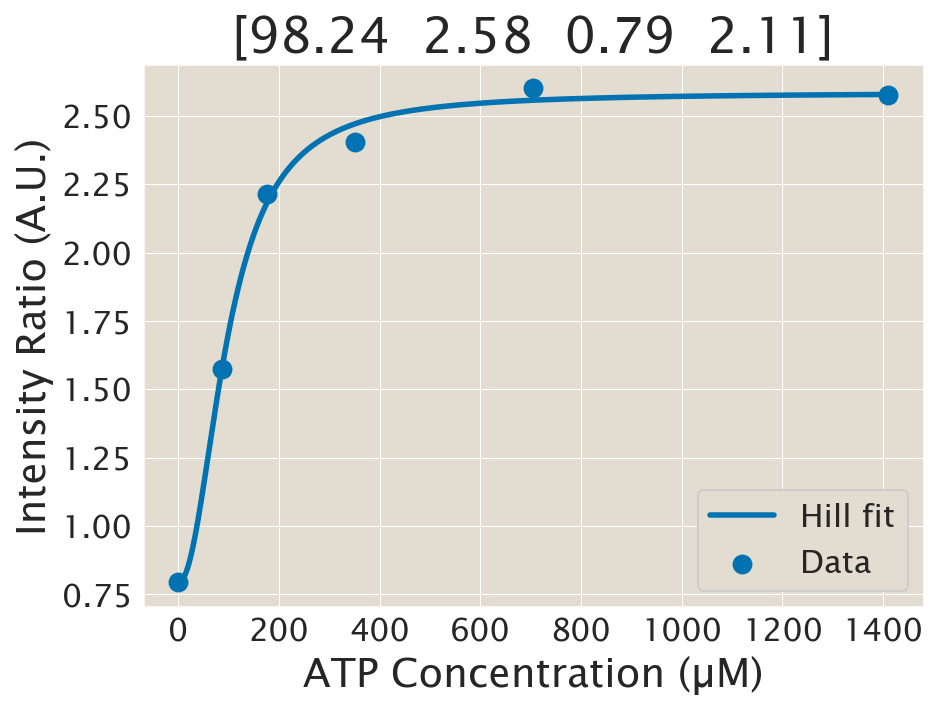

In [30]:
fig, axes = plt.subplots()

plt.scatter(ATPconc[:], ratio_calavg[:], label = 'Data', s=80)
#plt.xscale('log')
plt.plot(xvals, curve, label='Hill fit', linewidth = 2.75)
plt.legend(loc = 'lower right', fontsize = 16)
plt.xlabel('ATP Concentration (µM)', fontsize = 20)
plt.ylabel('Intensity Ratio (A.U.)', fontsize = 20)
#plt.title('ATP Calibration Curve', fontsize = 25)
plt.title(str(roundedparams), fontsize = 25)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
fig.savefig('2022-06-29_ATeam_Cal_1--Kd=742_Rr=1.49_Rm=0.78_n=2.02.png', transparent = True, dpi=400)

## Radial Trace - Noise Evaluation

In [31]:
r_inner = 0
r_outer = radius
print('r_inner: ' + str(r_inner*um_per_pixel) + ' µm, r_outer: ' +str(r_outer*um_per_pixel) + ' µm')

r_inner: 0.0 µm, r_outer: 223.29999999999998 µm


In [32]:
def profile_fn(im,
               r_min=2.5,
               dr=1.5,
               r_max=None,
               avg_method='median',
               n_positions=100,
               n_wedge=16):
    """
    Calculate the radial intensity profile of an image, 
    assuming that the (0,0) coordinate is at the center of the image.
    
    Parameters
    ----------
    im : numpy array
        The cropped image of the aster (grayscale).
      
    r_min : float
        Minimum radius beyond which the intensity profile is calculated [px].
    
    dr : float
        Radial binning size [px].
    
    avg_method : string
        The method used for doing a radial average of intensities.
        'median' - median averaging
        'mean' - mean averaging
        
    n_positions : integer
        Number of uniformly spaced radial positions where the average
        intensity is calculated.
        
    n_wedge : integer
        Number of angular bins
        
                      
    Returns
    -------
    profile_output : dictionary
        Dictionary of different outputs listed below
    
      r_unif_ls : numpy array
          Uniformly spaced radii where the average intensity is evaluated.
          
      avg_ls : numpy array
          Average intensities evaluated at 'n_positions' different uniformly
          spaced radii.
          
      std_ls : numpy array
          Standard deviations of intensity values in differents wedges
          
      avg_bin_mat : numpy array
          Two dimensional array to store the average fluorescence values
          at each of 'n_positions' radii and for each angular bin
          
      angles : numpy array
          List of average angles at different bins. E.g., if the upper and
          lower θ-limits are (30° and 60°), then the corresponding element
          in angles will be 45°.
          
      r_ls : numpy array
          Radial distances of all image pixels from the image center.
          
      im_ls : numpy array
          All pixel intensities in the same order as 'r_ls'.
    """

    # Ensure that the image is a numpy array
    if not isinstance(im, np.ndarray):
        im = np.array(im)

    # Dimensions of the image
    H, W = im.shape

    # Array of the radial distance of each point from the center
    x_mat, y_mat = np.meshgrid(np.arange(W), np.arange(H))
    x_center = 0.5 * W - 0.5
    y_center = 0.5 * H - 0.5
    r_mat = np.sqrt((x_mat - x_center)**2 + (y_mat - y_center)**2)
    angle_mat = np.mod(np.arctan2(y_mat - y_center, x_mat - x_center),
                       2 * np.pi)

    # Convert 2d arrays into 1d arrays
    r_ls = r_mat.flatten()
    im_ls = im.flatten()
    angle_ls = angle_mat.flatten()

    # Uniformly spaced radii, starting with r_min and
    # ending with the smallest dimension of the image halved,
    # if r_max is not explicitly specified
#     if type(r_max) != np.ndarray:
#         r_max = 0.5 * np.min([H, W]) - 0.5

    r_unif_ls = np.linspace(r_min, r_max, n_positions)

    # List of bin angles
    angle_bins = np.radians(np.linspace(0, 360, n_wedge + 1))
    angles = 0.5 * (angle_bins[1:] + angle_bins[0:-1])

    # Matrix to store average profiles in each radial bin
    avg_bin_mat = [[] for _ in range(n_wedge)]

    for i, r in enumerate(r_unif_ls):
        dat = im_ls[(r_ls > r - 0.5 * dr) & (r_ls < r + 0.5 * dr)]
        angle_disk = angle_ls[(r_ls > r - 0.5 * dr) & (r_ls < r + 0.5 * dr)]

        for k in range(n_wedge):
            dat_bin = dat[(angle_disk > angle_bins[k])
                          & (angle_disk <= angle_bins[k + 1])]

            if avg_method == 'median':
                avg_dat_bin = np.median(dat_bin)
            elif avg_method == 'mean':
                avg_dat_bin = np.mean(dat_bin)
            avg_bin_mat[k].append(avg_dat_bin)

    avg_bin_mat = np.array(avg_bin_mat)
    if avg_method == 'median':
        avg_ls = np.nanmedian(avg_bin_mat, axis=0)
    elif avg_method == 'mean':
        avg_ls = np.nanmean(avg_bin_mat, axis=0)
    else:
        raise ValueError('Incorrect averaging method specified.')

    std_ls = np.std(avg_bin_mat, axis=0)

    # Keep only the points inside the disk
    im_ls = im_ls[r_ls <= r_max]
    r_ls = r_ls[r_ls <= r_max]

    profile_output = {
        "r_unif_ls": r_unif_ls,
        "r_unif_ls_um": r_unif_ls * um_per_pixel,
        "avg_ls": avg_ls,
        "std_ls": std_ls,
        "avg_bin_mat": avg_bin_mat,
        "angles": angles,
        "r_ls": r_ls,
        "im_ls": im_ls
    }

    return profile_output

In [33]:
# getting GFP, CFP, MT, Cherry profiles averaged across radial blocks
output_YFP = []
output_CFP = []
output_ratios = []

num_pos = 100

avg_method_default = 'mean'
for i, im in enumerate(tqdm(ratio_circlecrop)):
    prof_YFP = profile_fn(YFP_circlecrop[i],
                          r_min=r_outer,
                          r_max=r_inner,
                         avg_method=avg_method_default,
                         n_positions=num_pos)
    output_YFP.append(prof_YFP)
    
    prof_CFP = profile_fn(CFP_circlecrop[i],
                          r_min=r_outer,
                          r_max=r_inner,
                         avg_method=avg_method_default,
                         n_positions=num_pos)
    output_CFP.append(prof_CFP)
    
    prof_ratios = profile_fn(im,
                          r_min=r_outer,
                          r_max=r_inner,
                         avg_method=avg_method_default,
                         n_positions=num_pos)
    output_ratios.append(prof_ratios)

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/anaduarte/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/anaduarte/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_52068/576398897.py:120: RuntimeWarning: Mean of empty slice
  avg_ls = np.nanmean(avg_bin_mat, axis=0)


1410
705
352
176
88
0


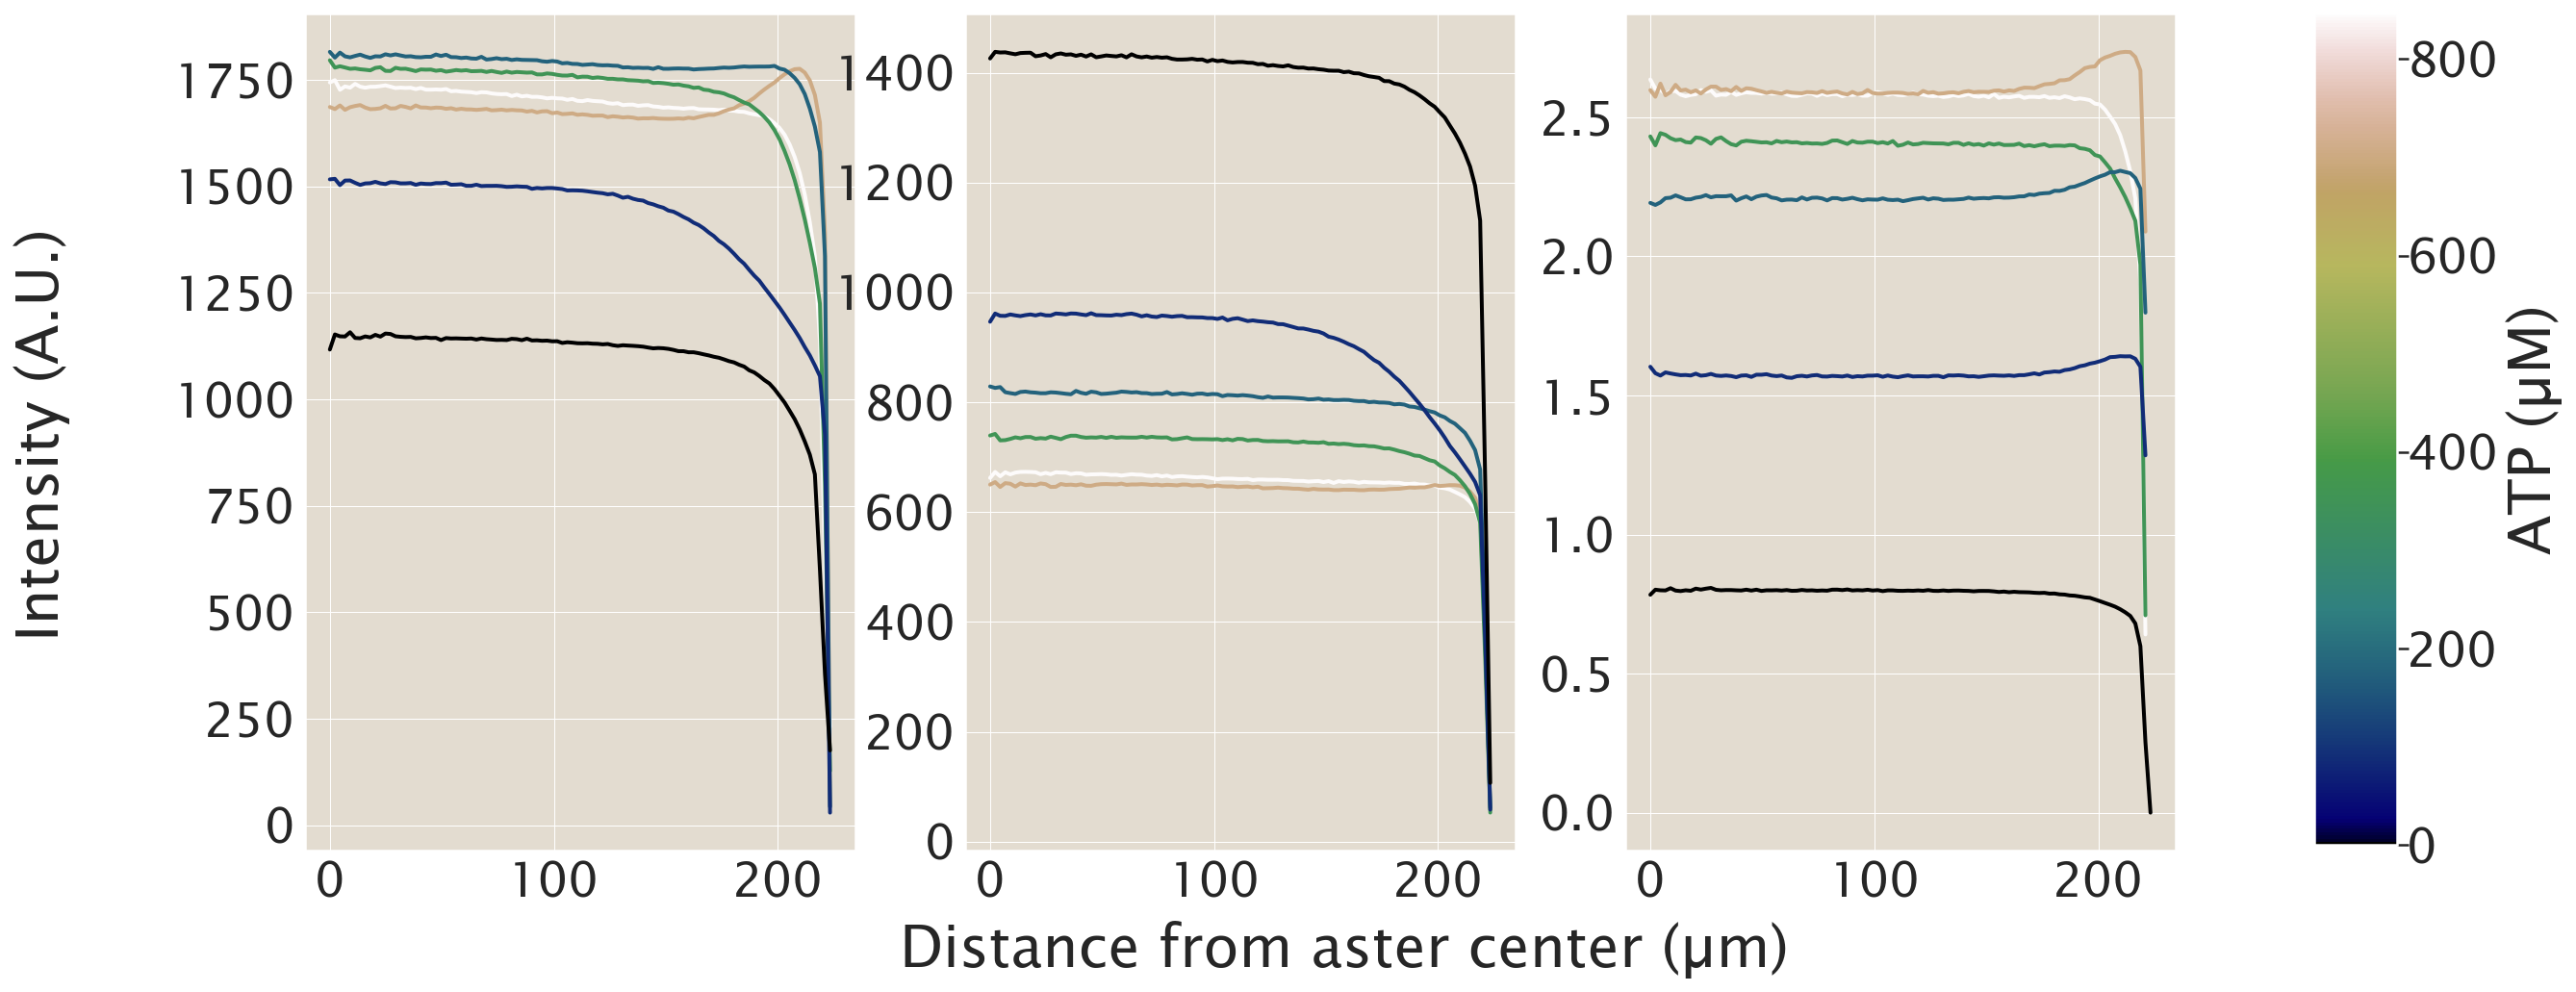

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(20, 8))

# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=ATPconc.min(), vmax=0.6*ATPconc.max())
colormap = cm.gist_earth
scalarmappable = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappable.set_array(ATPconc)

for i, conc in enumerate(ATPconc):
    print(conc)

    ax[0].plot(output_YFP[i]['r_unif_ls_um'],
             output_YFP[i]['avg_ls'],
             lw=2,
             color = colormap(normalize(conc)),
             label=str(conc))

    ax[1].plot(output_CFP[i]['r_unif_ls_um'],
             output_CFP[i]['avg_ls'],
             lw=2,
             color = colormap(normalize(conc)),
             label=str(conc))
    
    ax[2].plot(output_ratios[i]['r_unif_ls_um'],
             output_ratios[i]['avg_ls'],
             lw=2,
             color = colormap(normalize(conc)),
             label=str(conc))



fig.supxlabel('Distance from aster center (µm)', fontsize=30)
fig.supylabel('Intensity (A.U.)', fontsize=30)
# ax[0].set_ylabel('Motor Concentration (µM)')
# ax[1].set_ylabel('ATP Concentration (µM)')
# ax[0].set_xlabel('Distance from aster center (µm)')
# ax[1].set_xlabel('Distance from aster center (µm)')

ax[0].tick_params('both', labelsize=25)
ax[1].tick_params('both', labelsize=25)
ax[2].tick_params('both', labelsize=25)

fig.subplots_adjust(right=0.8)
color_bar_ax = fig.add_axes([0.85, 0.13, 0.03, 0.75])
cbar = fig.colorbar(scalarmappable, cax=color_bar_ax)
cbar.ax.tick_params(labelsize=25)
cbar.set_label(label="ATP (µM)", size=30, weight='bold')

# scalarmappable = cm.ScalarMappable(norm=normalize, cmap=colormap)
# scalarmappable.set_array(plot_times)
# cbar = plt.colorbar(scalarmappable, label = "Times (min)")

#fig.savefig('../../figures/Motor_ATP_Traces')

Text(0.5, 1.0, 'ATP = 0 (µM)')

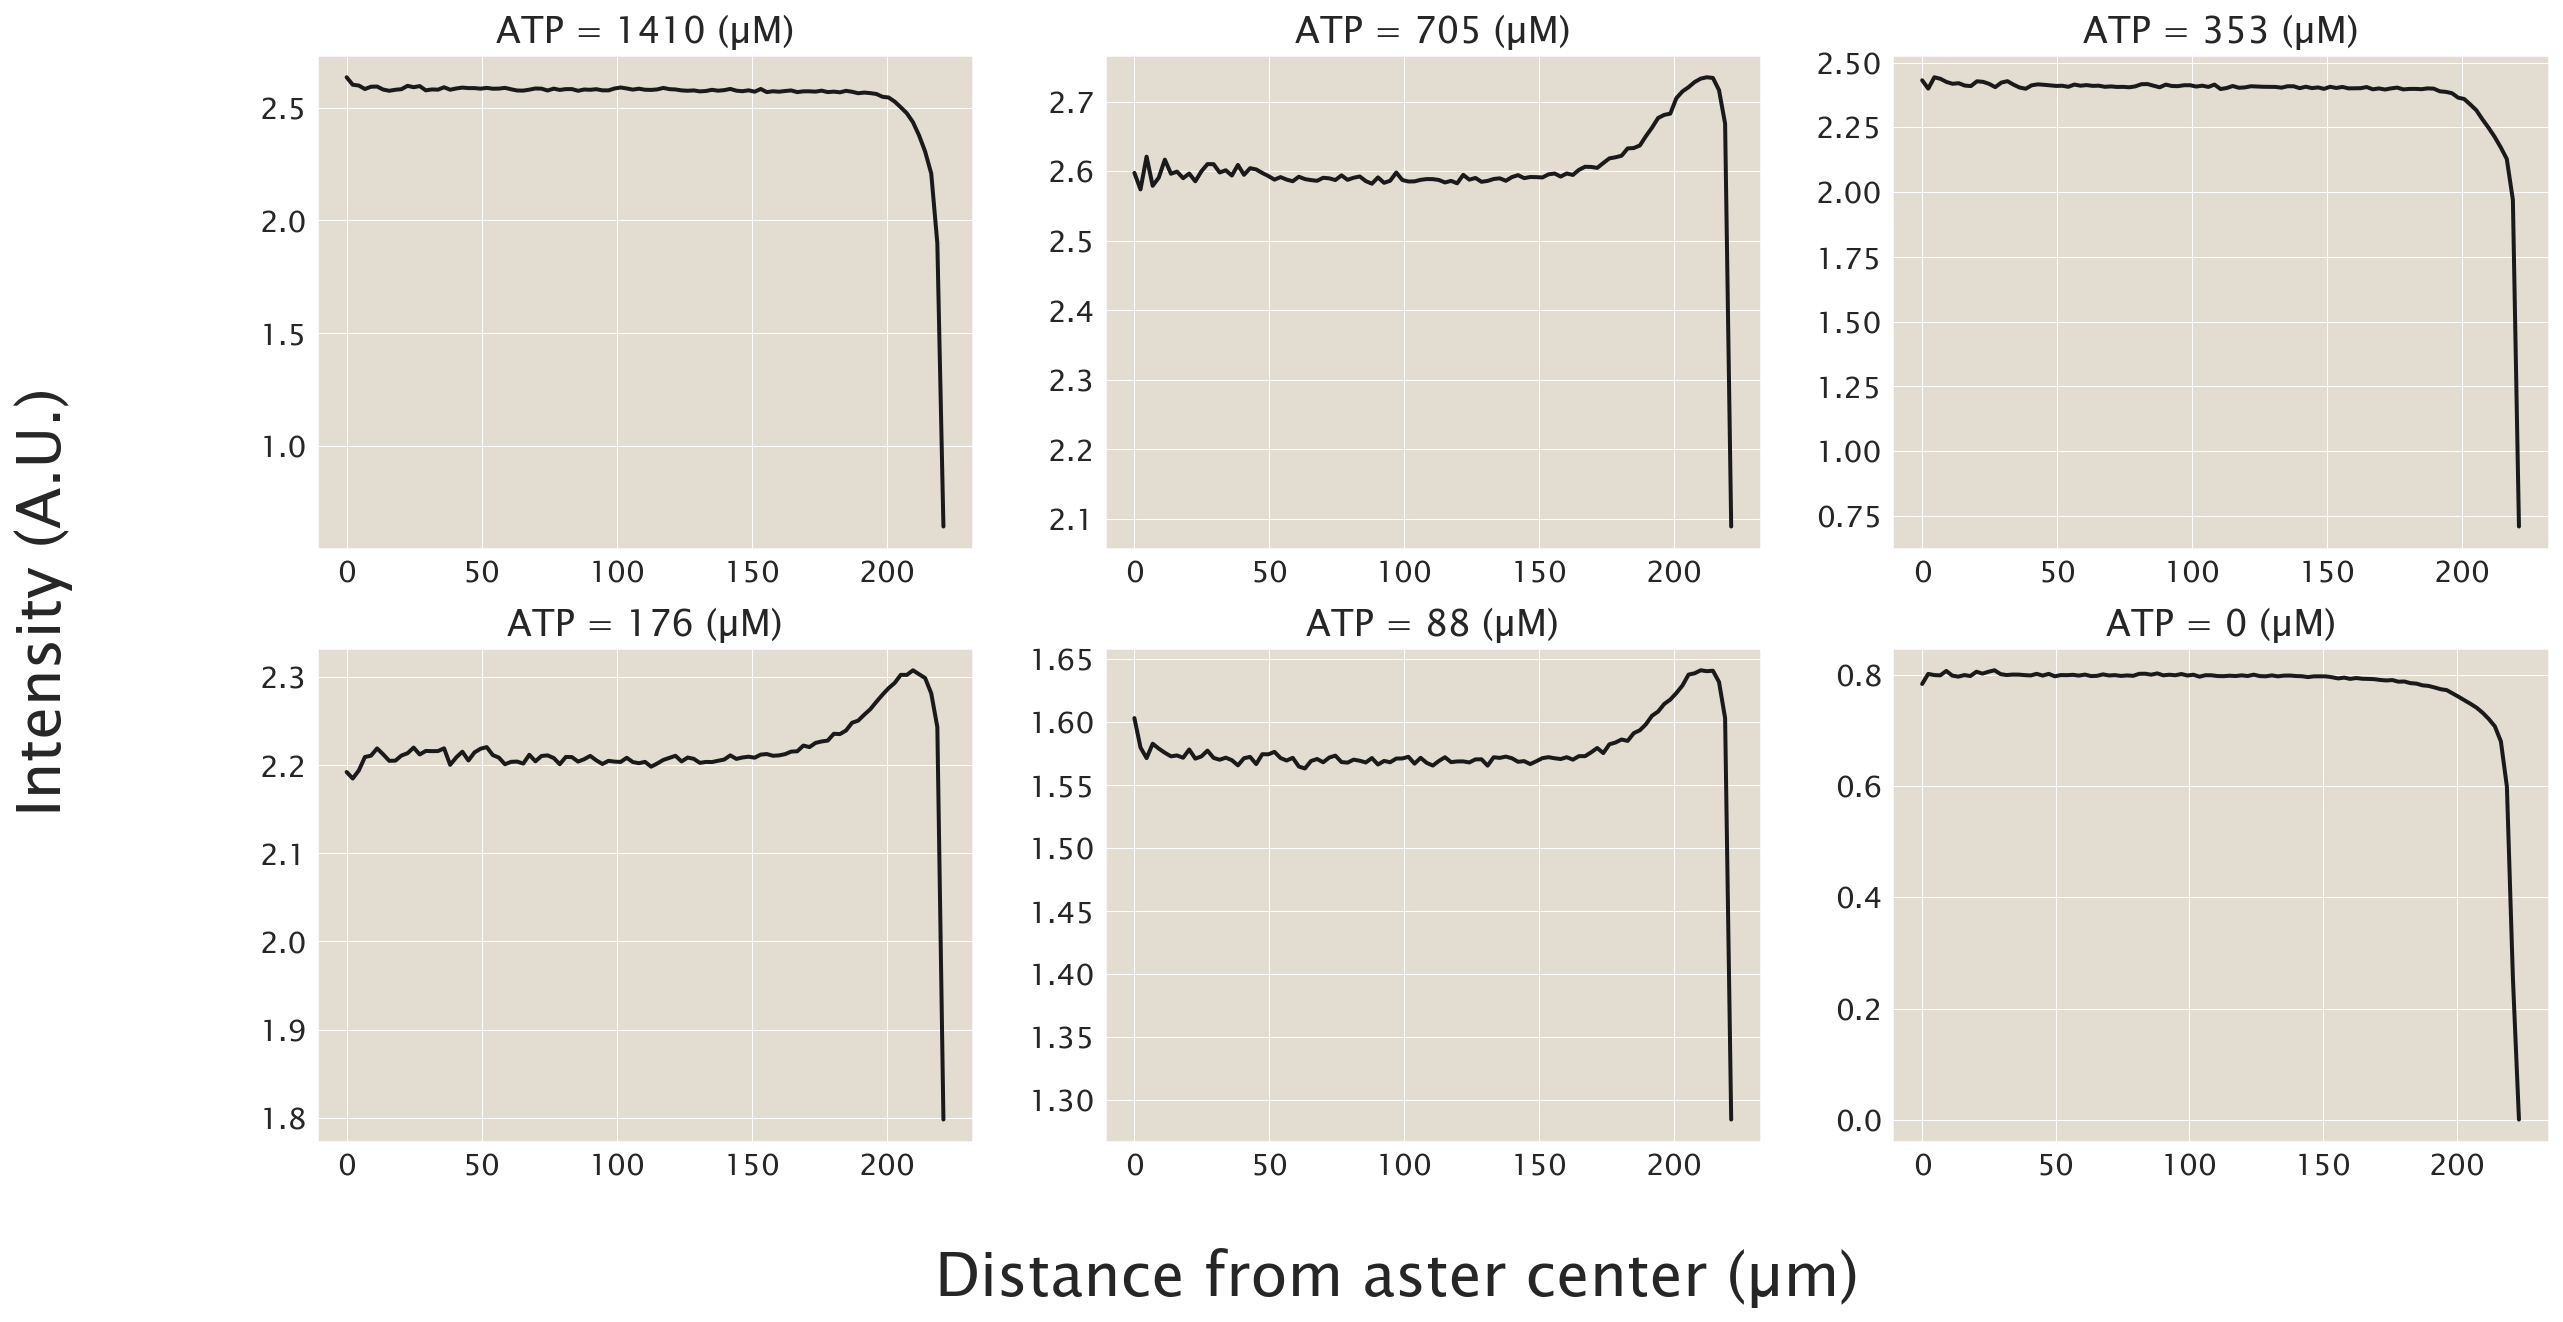

In [35]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

ax[0][0].plot(output_ratios[0]['r_unif_ls_um'],
         output_ratios[0]['avg_ls'],
         lw=2,
         color = 'k',
         label=str(conc))

ax[0][1].plot(output_ratios[1]['r_unif_ls_um'],
         output_ratios[1]['avg_ls'],
         lw=2,
         color = 'k',
         label=str(conc))

ax[0][2].plot(output_ratios[2]['r_unif_ls_um'],
         output_ratios[2]['avg_ls'],
         lw=2,
         color = 'k',
         label=str(conc))

ax[1][0].plot(output_ratios[3]['r_unif_ls_um'],
         output_ratios[3]['avg_ls'],
         lw=2,
         color = 'k',
         label=str(conc))

ax[1][1].plot(output_ratios[4]['r_unif_ls_um'],
         output_ratios[4]['avg_ls'],
         lw=2,
         color = 'k',
         label=str(conc))

ax[1][2].plot(output_ratios[5]['r_unif_ls_um'],
         output_ratios[5]['avg_ls'],
         lw=2,
         color = 'k',
         label=str(conc))



fig.supxlabel('Distance from aster center (µm)', fontsize=30)
fig.supylabel('Intensity (A.U.)', fontsize=30)
# ax[0].set_ylabel('Motor Concentration (µM)')
# ax[1].set_ylabel('ATP Concentration (µM)')
# ax[0].set_xlabel('Distance from aster center (µm)')
# ax[1].set_xlabel('Distance from aster center (µm)')

ax[0][0].tick_params('both', labelsize=15)
ax[0][1].tick_params('both', labelsize=15)
ax[0][2].tick_params('both', labelsize=15)
ax[1][0].tick_params('both', labelsize=15)
ax[1][1].tick_params('both', labelsize=15)
ax[1][2].tick_params('both', labelsize=15)

ax[0][0].set_title('ATP = 1410 (µM)')
ax[0][1].set_title('ATP = 705 (µM)')
ax[0][2].set_title('ATP = 353 (µM)')
ax[1][0].set_title('ATP = 176 (µM)')
ax[1][1].set_title('ATP = 88 (µM)')
ax[1][2].set_title('ATP = 0 (µM)')

#fig.savefig('../../figures/Motor_ATP_Traces')

covariance -  two ideas both are that looking at how noise varies with signal
1) is the idea that for two intensity levels compare the amopunts of noise
2) because in asters, the signal changes from the center out you compare the deviation from the mean for each point i.e. the noise and then look at how that trends across the line - **i think it is this